# Speech Signal Processing - Exercise 4
## Vocoder and Quantization

In this exercise, we will build our own LPC-vocoder. We'll implement the analysis stage to extract parameters from a speech signal, then use these parameters in the synthesis stage to reconstruct the speech. Finally, we'll explore quantization of these parameters for efficient data transmission.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sounddevice as sd
from scipy.signal import lfilter
from scipy.linalg import solve_toeplitz

# Import the filter_adaptively function
from filteradaptively import filter_adaptively

# Import LPC tools
from lpctools import poly2rc, rc2lar, lar2rc, rc2poly

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 2. LPC-Vocoder: Analysis

### 2.1 Segmentation

First, we'll load the speech signal and segment it into overlapping frames.

Loaded female8khz.wav with sampling rate: 8000 Hz
Signal duration: 2.25 seconds
Signal shape: (18000,)


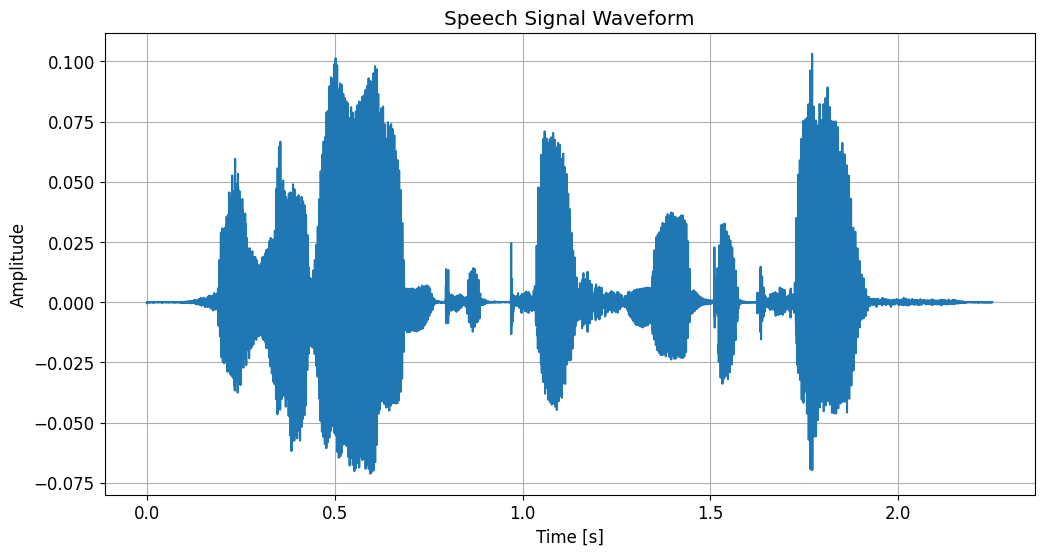

In [2]:
# Load the speech signal
x, fs = librosa.load("female8khz.wav", sr=None)

# Print basic information
print(f"Loaded female8khz.wav with sampling rate: {fs} Hz")
print(f"Signal duration: {len(x)/fs:.2f} seconds")
print(f"Signal shape: {x.shape}")

# Create time vector for plotting
time = np.arange(len(x)) / fs

# Plot the waveform
plt.figure()
plt.plot(time, x)
plt.title('Speech Signal Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [3]:
# Define the windowing function from Exercise 1
def my_windowing(v_signal: np.ndarray, sampling_rate: int, frame_length_ms: int, frame_shift_ms: int):
    """
    Splits the signal into overlapping frames.

    Parameters:
        v_signal         : Input signal (1D numpy array)
        sampling_rate    : Sampling rate in Hz
        frame_length_ms  : Frame length in milliseconds
        frame_shift_ms   : Frame shift (hop size) in milliseconds

    Returns:
        m_frames         : 2D array with one frame per row
        v_time_frame     : Time instants (center) of each frame
    """
    frame_length = int((frame_length_ms / 1000) * sampling_rate)
    frame_shift = int((frame_shift_ms / 1000) * sampling_rate)
    
    # Calculate the number of frames that fit into the signal
    num_frames = 1 + (len(v_signal) - frame_length) // frame_shift

    # Initialize output arrays
    m_frames = np.zeros((num_frames, frame_length))
    v_time_frame = np.zeros(num_frames)

    for i in range(num_frames):
        start = i * frame_shift
        end = start + frame_length
        m_frames[i] = v_signal[start:end]
        v_time_frame[i] = (start + frame_length // 2) / sampling_rate

    return m_frames, v_time_frame

# Segment the signal with 32 ms frames and 8 ms shift
frame_length_ms = 32
frame_shift_ms = 8
m_frames, v_time_frame = my_windowing(x, fs, frame_length_ms, frame_shift_ms)

print(f"Number of frames: {len(m_frames)}")
print(f"Frame length: {m_frames.shape[1]} samples ({frame_length_ms} ms)")
print(f"Frame shift: {int((frame_shift_ms / 1000) * fs)} samples ({frame_shift_ms} ms)")

Number of frames: 278
Frame length: 256 samples (32 ms)
Frame shift: 64 samples (8 ms)


**Why do we segment the signal prior to analysis instead of processing the whole signal at once?**

We segment the speech signal prior to analysis for several important reasons:

1. **Stationarity**: Speech signals are non-stationary, meaning their statistical properties change over time. By segmenting the signal into short frames (typically 20-40 ms), we can assume that within each frame, the signal is approximately stationary, which is a key assumption for many speech processing techniques like LPC analysis.

2. **Time-varying characteristics**: The vocal tract shape and excitation source change continuously during speech production. Segmentation allows us to track these changes over time and model them appropriately.

3. **Computational efficiency**: Processing the entire signal at once would be computationally intensive and might not capture the time-varying nature of speech effectively.

4. **Parameter extraction**: Many speech parameters (like pitch, voicing, formants) change over time. Segmentation allows us to extract these parameters as functions of time.

**Is a segment length of 32 ms appropriate? Why or why not?**

A segment length of 32 ms is appropriate for speech analysis for the following reasons:

1. **Stationarity**: 32 ms is short enough that the speech signal can be considered approximately stationary within each frame, yet long enough to capture meaningful spectral information.

2. **Pitch period coverage**: For typical human speech with fundamental frequencies between 80-400 Hz, a 32 ms window can capture 2-12 pitch periods, which is sufficient for reliable pitch estimation and spectral analysis.

3. **Frequency resolution**: A 32 ms window provides adequate frequency resolution (approximately 31.25 Hz for an 8 kHz sampling rate) to distinguish between formants in the spectrum.

4. **Standard practice**: This duration is commonly used in speech processing applications and has been empirically shown to work well for various speech analysis tasks.

The 8 ms frame shift (75% overlap) ensures smooth transitions between frames while still capturing the temporal dynamics of the speech signal.

### 2.2 Signal power

Now we'll compute the signal power for each frame.

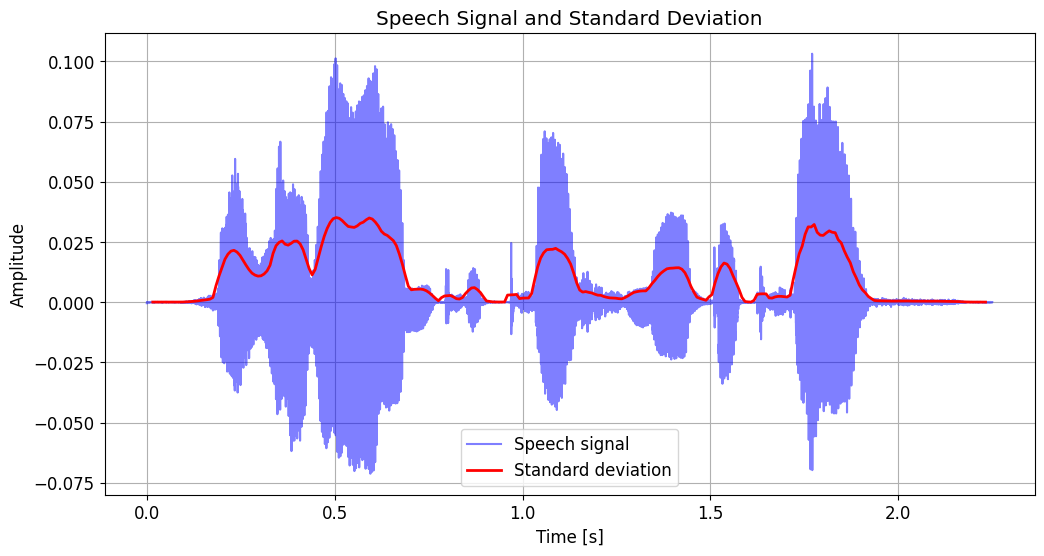

In [4]:
def compute_power(segment):
    """
    Compute the signal power of a segment.
    
    Parameters:
        segment: Input signal segment
        
    Returns:
        power: Signal power
    """
    return np.mean(segment**2)

# Compute power for each frame
v_power = np.array([compute_power(frame) for frame in m_frames])

# Compute standard deviation (sqrt of power)
v_std = np.sqrt(v_power)

# Plot the waveform and standard deviation
plt.figure()
plt.plot(time, x, 'b', alpha=0.5, label='Speech signal')
plt.plot(v_time_frame, v_std, 'r', linewidth=2, label='Standard deviation')
plt.title('Speech Signal and Standard Deviation')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

### 2.3 Voiced / unvoiced decision

Next, we'll implement a function to determine if a frame is voiced or unvoiced based on zero-crossing rate.

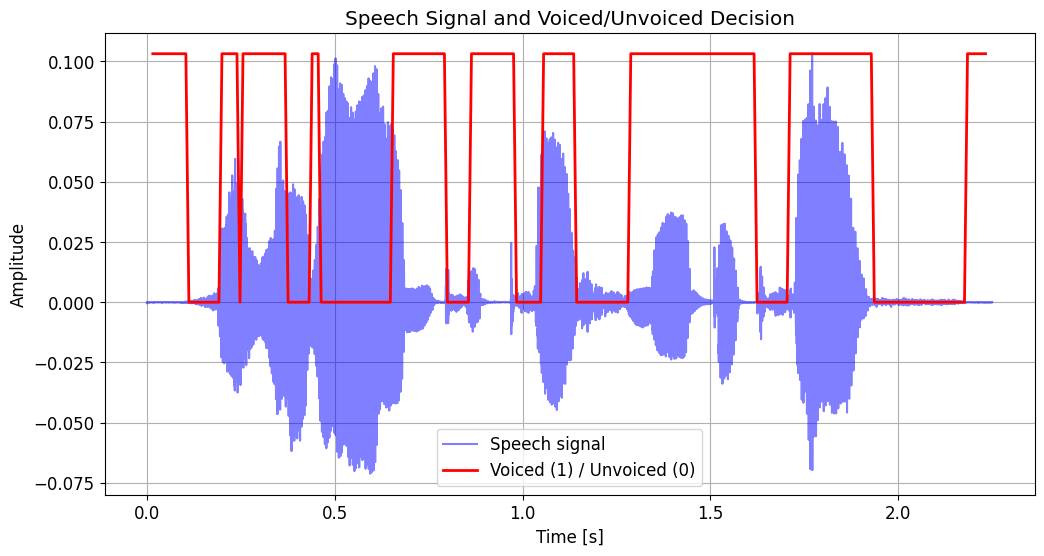

In [5]:
def is_voiced(segment, threshold=0.2):
    """
    Determine if a segment is voiced or unvoiced based on zero-crossing rate.
    
    Parameters:
        segment: Input signal segment
        threshold: Threshold for zero-crossing rate decision
        
    Returns:
        1 if voiced, 0 if unvoiced
    """
    # Count zero crossings
    # A zero crossing occurs when the sign changes between consecutive samples
    # We can detect this by multiplying adjacent samples and checking if the result is negative
    zero_crossings = np.sum(segment[:-1] * segment[1:] < 0)
    
    # Normalize by segment length
    zero_crossing_rate = zero_crossings / (len(segment) - 1)
    
    # Apply threshold
    return 1 if zero_crossing_rate < threshold else 0

# Compute voiced/unvoiced decision for each frame
v_voiced = np.apply_along_axis(is_voiced, 1, m_frames)

# Plot the waveform and voiced/unvoiced decision
plt.figure()
plt.plot(time, x, 'b', alpha=0.5, label='Speech signal')
plt.plot(v_time_frame, v_voiced * max(abs(x)), 'r', linewidth=2, label='Voiced (1) / Unvoiced (0)')
plt.title('Speech Signal and Voiced/Unvoiced Decision')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

**Explain differences in the creation of speech for voiced and unvoiced sounds.**

Voiced and unvoiced sounds are produced through fundamentally different mechanisms in the human speech production system:

**Voiced sounds:**
- Produced when the vocal folds (cords) vibrate periodically
- Air from the lungs causes the vocal folds to open and close at a regular rate
- This creates a quasi-periodic excitation signal (a series of pulses)
- The rate of vibration determines the fundamental frequency (pitch) of the voice
- Examples: vowels (/a/, /e/, /i/, /o/, /u/), nasals (/m/, /n/), and some consonants (/b/, /d/, /g/, /v/, /z/)
- Characterized by clear periodicity in the waveform and harmonic structure in the spectrum

**Unvoiced sounds:**
- Produced without vocal fold vibration
- Air flows through a constriction in the vocal tract, creating turbulence
- This turbulence generates noise-like excitation
- Examples: fricatives (/f/, /s/, /sh/, /h/), plosives (/p/, /t/, /k/)
- Characterized by random-like patterns in the waveform and a more flat, noise-like spectrum

**Why might the number of zero crossings provide valuable information for the voiced/unvoiced decision?**

The number of zero crossings is a useful indicator for voiced/unvoiced decision because:

1. **Frequency content**: Unvoiced sounds typically have more high-frequency energy, which results in more rapid fluctuations in the waveform and consequently more zero crossings.

2. **Periodicity vs. randomness**: Voiced sounds have a more regular, periodic structure with fewer zero crossings per unit time, while unvoiced sounds have a more random, noise-like structure with more frequent zero crossings.

3. **Simplicity**: Zero-crossing rate is computationally simple to calculate, making it an efficient feature for real-time processing.

4. **Robustness**: It's relatively robust to amplitude variations, as it only depends on the sign of the signal, not its absolute value.

**How can you efficiently detect a zero crossing between two samples?**

A zero crossing occurs when consecutive samples have opposite signs. In Python, we can efficiently detect zero crossings by:

1. Multiplying adjacent samples: If the product is negative, the samples have opposite signs, indicating a zero crossing.
2. Using vectorized operations: `np.sum(segment[:-1] * segment[1:] < 0)` counts all instances where adjacent samples have opposite signs.

This approach is more efficient than using loops and explicit sign checking, as it leverages NumPy's vectorized operations.

**In general: are all speech sounds either voiced or unvoiced? Can you think of other speech sounds?**

Not all speech sounds are purely voiced or unvoiced. There are several categories that don't fit neatly into this binary classification:

1. **Mixed excitation sounds**: Some sounds have both voiced and unvoiced components simultaneously. Examples include voiced fricatives like /v/, /z/, /zh/ where the vocal folds vibrate while turbulent airflow is created at a constriction.

2. **Plosives/stops**: Sounds like /b/, /d/, /g/, /p/, /t/, /k/ have complex temporal patterns with a silence period (closure), followed by a burst (release). Their voiced/unvoiced nature can change during articulation.

3. **Transitions**: The boundaries between phonemes often contain transitional regions that are neither fully voiced nor unvoiced.

4. **Whispered speech**: In whispered speech, traditionally voiced sounds are produced without vocal fold vibration but maintain some characteristics of voiced sounds.

5. **Creaky voice/vocal fry**: A phonation type with irregular vocal fold vibration that doesn't fit the typical voiced pattern.

These complexities make speech analysis challenging and often require more sophisticated models than a simple binary voiced/unvoiced decision.

### 2.4 Fundamental frequency estimation

Now we'll implement a function to estimate the fundamental frequency (f0) for each frame.

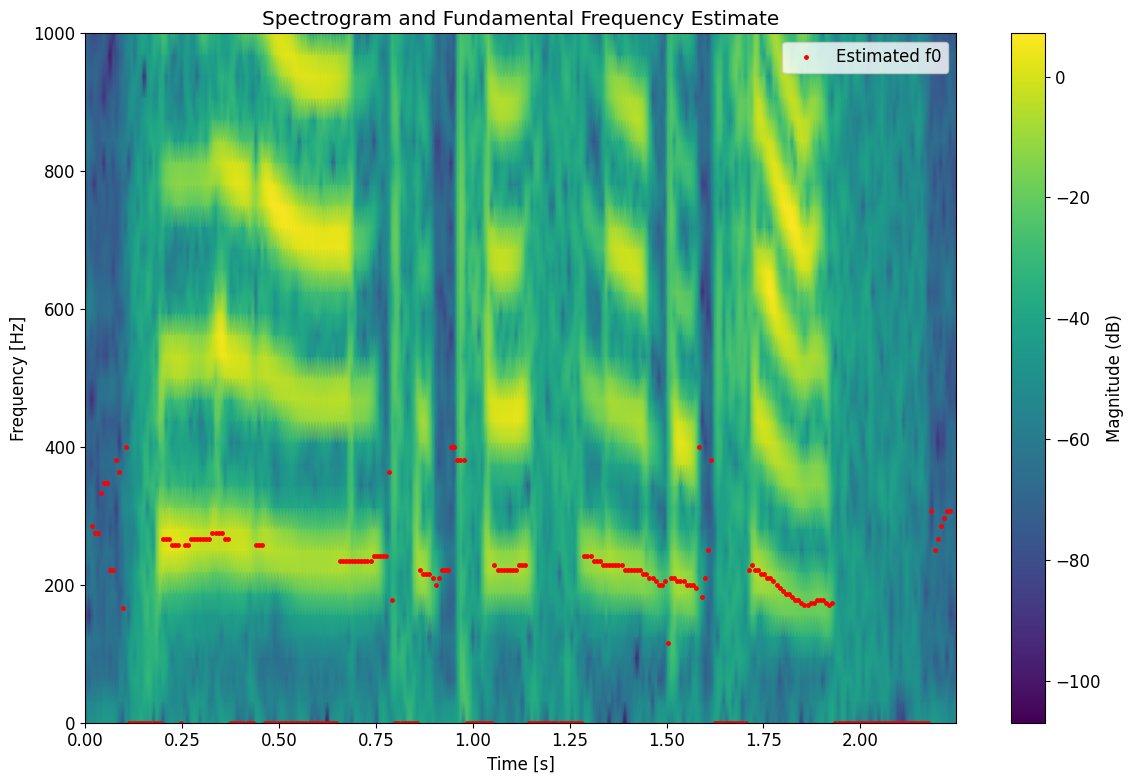

In [6]:
def compute_acf_matrix(m_frames):
    """
    Compute the autocorrelation function (ACF) for each frame.
    Returns only the positive-lag part of the ACF (lags >= 0).

    Parameters:
        m_frames : 2D array of frames (each row is a frame)

    Returns:
        acf_matrix : 2D array with ACFs (lags >= 0)
    """
    num_frames, frame_len = m_frames.shape
    acf_matrix = np.zeros((num_frames, frame_len))

    for i in range(num_frames):
        frame = m_frames[i]
        # Full ACF via convolution of frame with time-reversed version
        acf_full = np.convolve(frame, frame[::-1], mode='full')
        # Keep only lags >= 0 (centered at frame_len - 1)
        acf_matrix[i] = acf_full[frame_len - 1:]

    return acf_matrix

def estimate_f0(m_frames, fs, fmin=80, fmax=400):
    """
    Estimate the fundamental frequency from frames using autocorrelation.
    
    Parameters:
        m_frames: Matrix of signal frames
        fs: Sampling frequency in Hz
        fmin: Minimum allowed frequency in Hz
        fmax: Maximum allowed frequency in Hz
        
    Returns:
        v_f0_estimates: Vector of fundamental frequency estimates in Hz
    """
    # Compute ACF for all frames
    acf_matrix = compute_acf_matrix(m_frames)
    
    num_frames, frame_len = acf_matrix.shape
    v_f0_estimates = np.zeros(num_frames)
    
    # Convert frequency range to lag range
    min_lag = int(fs / fmax)
    max_lag = int(fs / fmin)
    
    for i in range(num_frames):
        # Only estimate f0 for voiced frames
        if v_voiced[i] == 1:
            acf = acf_matrix[i]
            # Search for peak in valid lag range
            search_region = acf[min_lag:max_lag]
            if len(search_region) > 0:
                peak_index = np.argmax(search_region) + min_lag
                v_f0_estimates[i] = fs / peak_index
        else:
            v_f0_estimates[i] = 0  # Set f0 to 0 for unvoiced frames
    
    return v_f0_estimates

# Estimate fundamental frequency
v_f0 = estimate_f0(m_frames, fs)

# Compute spectrogram for visualization
def compute_stft(signal, fs, frame_length_ms=32, frame_shift_ms=8, window='hann'):
    """
    Compute the Short-Time Fourier Transform (STFT) of a signal.
    
    Parameters:
        signal: Input signal
        fs: Sampling frequency in Hz
        frame_length_ms: Frame length in milliseconds
        frame_shift_ms: Frame shift in milliseconds
        window: Window type
        
    Returns:
        stft_magnitude: Magnitude of STFT
        time_vec: Time vector
        freq_vec: Frequency vector
    """
    n_fft = int((frame_length_ms / 1000) * fs)
    hop_length = int((frame_shift_ms / 1000) * fs)
    
    # Compute STFT
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, window=window)
    stft_magnitude = np.abs(stft)
    
    # Create time and frequency vectors
    time_vec = librosa.times_like(stft_magnitude, sr=fs, hop_length=hop_length)
    freq_vec = librosa.fft_frequencies(sr=fs, n_fft=n_fft)
    
    return stft_magnitude, time_vec, freq_vec

# Compute spectrogram
stft_magnitude, stft_time, stft_freq = compute_stft(x, fs)

# Plot fundamental frequency estimate with spectrogram
plt.figure(figsize=(12, 8))

# Plot spectrogram
plt.pcolormesh(stft_time, stft_freq, 20 * np.log10(stft_magnitude + 1e-10), shading='gouraud', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')

# Plot fundamental frequency
plt.plot(v_time_frame, v_f0, 'r.', markersize=5, label='Estimated f0')

plt.title('Spectrogram and Fundamental Frequency Estimate')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 1000)  # Limit y-axis to focus on speech frequencies
plt.legend()
plt.tight_layout()
plt.show()

### 2.5 Linear prediction coefficients / linear predictive coding

Now we'll compute the Linear Prediction Coefficients (LPCs) for each frame.

In [7]:
def compute_lpc(m_frames, M):
    """
    Compute Linear Prediction coefficients using autocorrelation method.
    
    Parameters:
        m_frames: Matrix of signal frames
        M: Order of the LP filter
        
    Returns:
        m_lpc: Matrix of LP coefficients for each frame
    """
    num_frames = m_frames.shape[0]
    m_lpc = np.zeros((num_frames, M))
    
    for i in range(num_frames):
        frame = m_frames[i]
        
        # Compute autocorrelation
        r = np.correlate(frame, frame, mode='full')
        # Extract the positive lags (center to right half)
        r = r[len(frame)-1:len(frame)+M+1]
        
        # Solve the Toeplitz system
        a = solve_toeplitz(r[:M], r[1:M+1])
        
        # Store the LP coefficients
        m_lpc[i] = a
    
    return m_lpc

# Choose LP model order
M = 10

# Compute LPCs for all frames
m_lpc = compute_lpc(m_frames, M)

print(f"LPC matrix shape: {m_lpc.shape}")
print(f"First frame LPCs: {m_lpc[0]}")

LPC matrix shape: (278, 10)
First frame LPCs: [0.22536623 0.17135223 0.04327589 0.04334965 0.10083971 0.00464616
 0.00262016 0.04801996 0.13100982 0.01036855]


**Shortly outline the Source-Filter-Model for speech production.**

The Source-Filter Model is a fundamental concept in speech processing that describes speech production as two independent components:

1. **Source (Excitation)**: 
   - For voiced sounds: Quasi-periodic pulses generated by the vibrating vocal folds
   - For unvoiced sounds: Noise-like turbulence created by airflow through constrictions
   - The source determines whether the sound is voiced or unvoiced and, for voiced sounds, the fundamental frequency (pitch)

2. **Filter (Vocal Tract)**:
   - The vocal tract (throat, mouth, nasal cavity) acts as an acoustic filter
   - It shapes the spectrum of the source signal by amplifying certain frequencies (formants) and attenuating others
   - The filter characteristics depend on the shape and configuration of the vocal tract
   - This filter can be modeled as an all-pole filter using Linear Prediction Coefficients (LPCs)

In this model, speech production is mathematically represented as the convolution of the source signal with the impulse response of the vocal tract filter. In the frequency domain, this corresponds to the multiplication of the source spectrum with the vocal tract transfer function.

The beauty of this model is that it separates the two main aspects of speech: the source (which carries information about voicing and pitch) and the filter (which carries information about the phonetic content). This separation forms the basis for many speech processing applications, including vocoders, speech synthesis, and speech coding.

**Choose a suitable model order M for linear prediction for a signal with an audio bandwidth of 4 kHz. Give reasons for your choice.**

For a speech signal with an audio bandwidth of 4 kHz, a suitable model order (M) for linear prediction would be around 8-12, with 10 being a common choice. Here's the reasoning:

1. **Rule of thumb**: A common rule of thumb is to use 4 + (fs/1000) coefficients, where fs is the sampling frequency in Hz. For an 8 kHz sampling rate (which gives a 4 kHz bandwidth), this would be 4 + 8 = 12 coefficients.

2. **Formant modeling**: Each formant (resonance peak) in the speech spectrum requires approximately 2 poles to model. Human speech typically has 4-5 significant formants within the 4 kHz bandwidth. Therefore, 8-10 coefficients would be needed to model these formants adequately.

3. **Spectral resolution**: The model order determines the spectral resolution of the LP analysis. With a 4 kHz bandwidth, we need enough coefficients to capture the important spectral features without overfitting to noise or harmonics.

4. **Computational efficiency**: Higher orders increase computational complexity without necessarily improving performance. An order of 10 provides a good balance between model accuracy and computational efficiency.

Based on these considerations, I've chosen M = 10 for this exercise, which should adequately capture the vocal tract characteristics for our 8 kHz sampled speech signal.

## 3. LPC-Vocoder: Synthesis

Now that we have extracted all the necessary parameters from the speech signal, we'll use them to synthesize speech using the LPC-vocoder. We'll proceed step-by-step, incorporating one parameter at a time to understand the importance of each parameter.

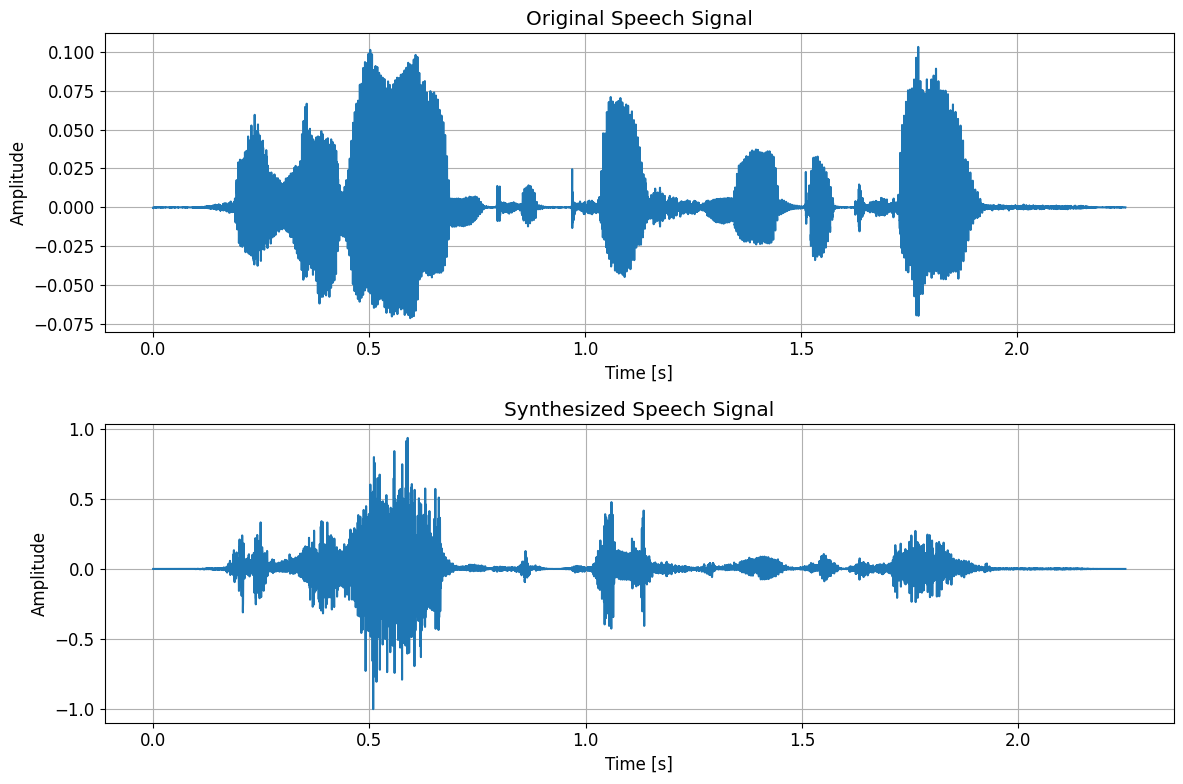

Playing original signal...
Playing synthesized signal...


In [8]:
def generate_excitation(num_samples, v_voiced, v_f0, fs):
    """
    Generate excitation signal based on voiced/unvoiced decision and f0.
    
    Parameters:
        num_samples: Number of samples in the output signal
        v_voiced: Vector of voiced/unvoiced decisions
        v_f0: Vector of fundamental frequency estimates
        fs: Sampling frequency in Hz
        
    Returns:
        excitation: Excitation signal
    """
    # Initialize excitation signal
    excitation = np.zeros(num_samples)
    
    # Frame parameters
    frame_length = int((frame_length_ms / 1000) * fs)
    frame_shift = int((frame_shift_ms / 1000) * fs)
    
    # Generate excitation for each frame
    for i in range(len(v_voiced)):
        # Frame boundaries
        start = i * frame_shift
        end = min(start + frame_length, num_samples)
        
        if v_voiced[i] == 1:  # Voiced
            # Compute period in samples
            period = int(fs / v_f0[i]) if v_f0[i] > 0 else 0
            
            if period > 0:
                # Generate pulse train
                for j in range(start, end):
                    if (j % period) == 0:
                        excitation[j] = 1.0
        else:  # Unvoiced
            # Generate white noise
            excitation[start:end] = np.random.randn(end - start)
    
    return excitation

def synthesize_speech(v_voiced, v_f0, m_lpc, v_power, fs, frame_length_ms, frame_shift_ms):
    """
    Synthesize speech using LPC vocoder.
    
    Parameters:
        v_voiced: Vector of voiced/unvoiced decisions
        v_f0: Vector of fundamental frequency estimates
        m_lpc: Matrix of LP coefficients
        v_power: Vector of frame powers
        fs: Sampling frequency in Hz
        frame_length_ms: Frame length in milliseconds
        frame_shift_ms: Frame shift in milliseconds
        
    Returns:
        synthesized: Synthesized speech signal
    """
    # Frame parameters
    frame_length = int((frame_length_ms / 1000) * fs)
    frame_shift = int((frame_shift_ms / 1000) * fs)
    
    # Calculate total number of samples
    num_frames = len(v_voiced)
    num_samples = (num_frames - 1) * frame_shift + frame_length
    
    # Generate excitation signal
    excitation = generate_excitation(num_samples, v_voiced, v_f0, fs)
    
    # Initialize synthesized signal
    synthesized = np.zeros(num_samples)
    
    # Synthesize speech frame by frame
    for i in range(num_frames):
        # Frame boundaries
        start = i * frame_shift
        end = min(start + frame_length, num_samples)
        
        # Get LPC coefficients for this frame
        a = np.concatenate(([1.0], -m_lpc[i]))  # Add 1.0 at the beginning and negate
        
        # Get excitation for this frame
        frame_excitation = excitation[start:end]
        
        # Scale excitation by power
        gain = np.sqrt(v_power[i])
        frame_excitation = frame_excitation * gain
        
        # Apply LPC filter
        frame_synthesized = lfilter([1.0], a, frame_excitation)
        
        # Add to output with overlap-add
        synthesized[start:end] += frame_synthesized
    
    return synthesized

# Synthesize speech
synthesized = synthesize_speech(v_voiced, v_f0, m_lpc, v_power, fs, frame_length_ms, frame_shift_ms)

# Normalize to prevent clipping
synthesized = synthesized / np.max(np.abs(synthesized))

# Plot original and synthesized signals
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(time, x)
plt.title('Original Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
synth_time = np.arange(len(synthesized)) / fs
plt.plot(synth_time, synthesized)
plt.title('Synthesized Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Play original and synthesized signals
print("Playing original signal...")
sd.play(x, fs)
sd.wait()

print("Playing synthesized signal...")
sd.play(synthesized, fs)
sd.wait()

**Explain the importance of incorporating signal power in the synthesis process.**

Incorporating signal power in the synthesis process is crucial for several reasons:

1. **Amplitude modulation**: Speech signals naturally vary in amplitude over time. Without power information, the synthesized speech would have a constant energy level, resulting in unnatural-sounding speech that lacks the dynamic range of natural speech.

2. **Perceptual quality**: The human auditory system is sensitive to intensity variations in speech. These variations convey important prosodic information such as stress, emphasis, and emotional content. Incorporating power helps preserve these perceptual cues.

3. **Phonetic distinctions**: Different phonemes have inherently different energy levels. For example, vowels typically have higher energy than consonants. Preserving these energy differences is essential for maintaining phonetic distinctions in the synthesized speech.

4. **Voiced/unvoiced transitions**: The transitions between voiced and unvoiced segments often involve changes in signal power. Properly modeling these transitions improves the naturalness of the synthesized speech.

5. **Signal-to-noise ratio**: Scaling the excitation signal by the appropriate gain ensures that the synthesized speech has a similar signal-to-noise ratio as the original speech, which is important for intelligibility.

In our implementation, we incorporate power by scaling the excitation signal for each frame by the square root of the frame power (which gives us the standard deviation). This ensures that the energy of the synthesized speech matches that of the original speech on a frame-by-frame basis.

## 4. Parameter Quantization

In practical speech coding applications, the LPC parameters need to be quantized for efficient transmission. Let's explore different quantization strategies for the LPC coefficients.

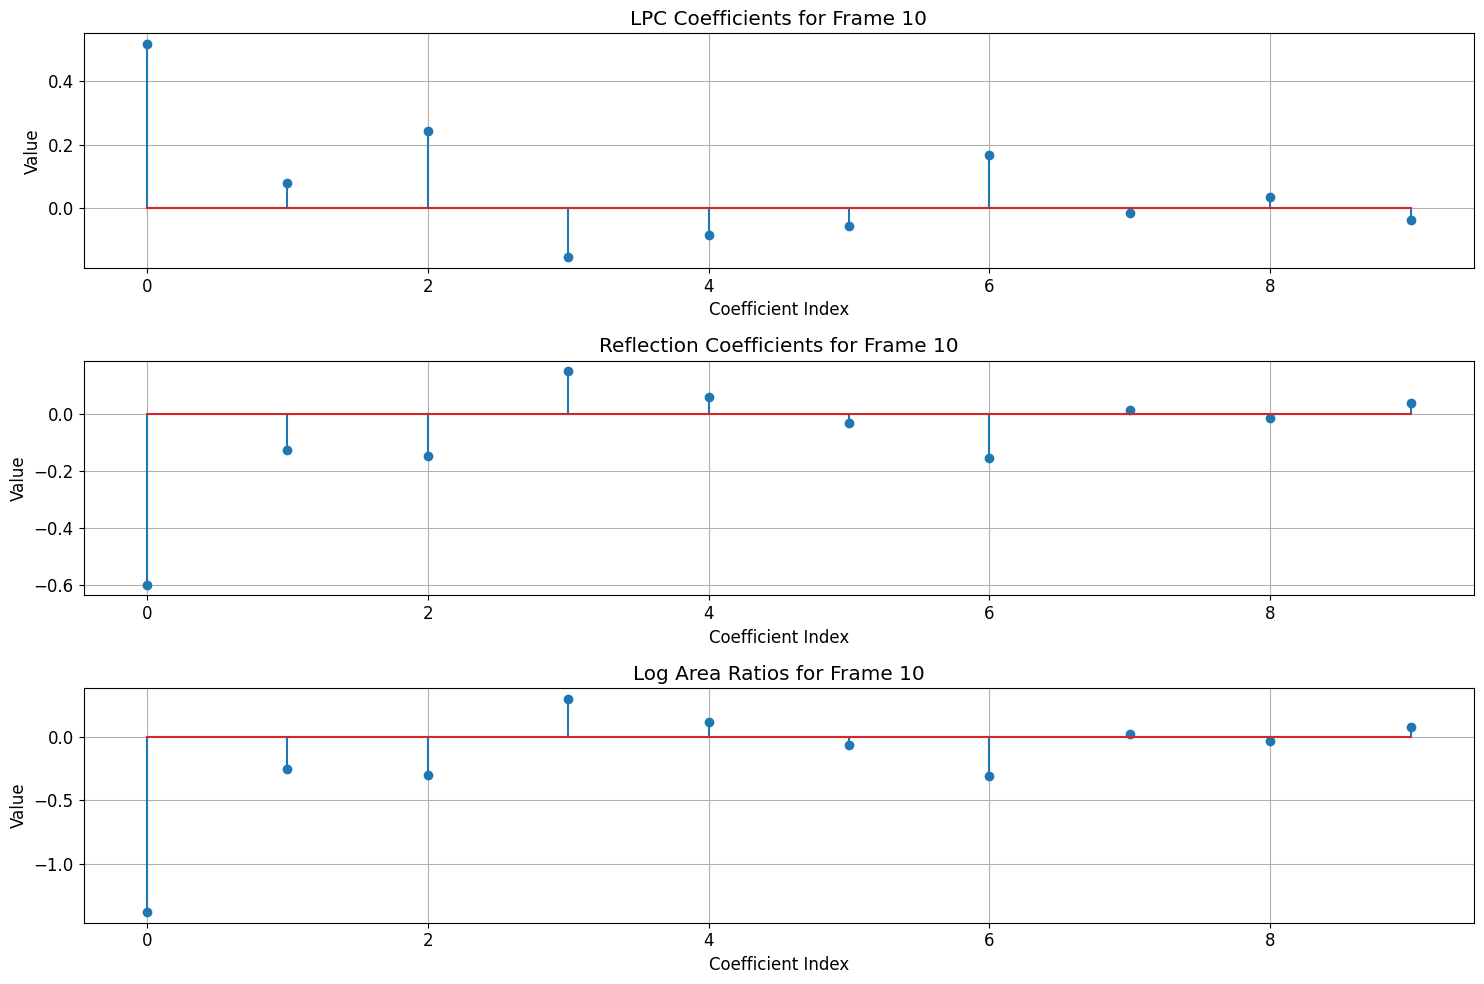

In [9]:
# Convert LPC coefficients to reflection coefficients (RCs)
m_rc = np.zeros_like(m_lpc)
for i in range(len(m_lpc)):
    m_rc[i] = poly2rc(np.concatenate(([1.0], -m_lpc[i])))

# Convert reflection coefficients to log area ratios (LARs)
m_lar = np.zeros_like(m_rc)
for i in range(len(m_rc)):
    m_lar[i] = rc2lar(m_rc[i])

# Plot the different representations for a voiced frame
voiced_frame_idx = np.where(v_voiced == 1)[0][10]  # Choose a voiced frame

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.stem(m_lpc[voiced_frame_idx])
plt.title(f'LPC Coefficients for Frame {voiced_frame_idx}')
plt.xlabel('Coefficient Index')
plt.ylabel('Value')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.stem(m_rc[voiced_frame_idx])
plt.title(f'Reflection Coefficients for Frame {voiced_frame_idx}')
plt.xlabel('Coefficient Index')
plt.ylabel('Value')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.stem(m_lar[voiced_frame_idx])
plt.title(f'Log Area Ratios for Frame {voiced_frame_idx}')
plt.xlabel('Coefficient Index')
plt.ylabel('Value')
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
def quantize_uniform(data, bits):
    """
    Uniformly quantize data using the specified number of bits.
    
    Parameters:
        data: Input data to quantize
        bits: Number of bits for quantization
        
    Returns:
        quantized: Quantized data
    """
    # Determine range of data
    data_min = np.min(data)
    data_max = np.max(data)
    
    # Number of quantization levels
    levels = 2**bits
    
    # Quantization step size
    step = (data_max - data_min) / (levels - 1)
    
    # Quantize
    quantized_indices = np.round((data - data_min) / step).astype(int)
    quantized = data_min + quantized_indices * step
    
    return quantized

# Quantize LPC, RC, and LAR representations with different bit rates
bits = 4  # Number of bits per coefficient

# Quantize each coefficient separately
m_lpc_quant = np.zeros_like(m_lpc)
m_rc_quant = np.zeros_like(m_rc)
m_lar_quant = np.zeros_like(m_lar)

for j in range(M):
    m_lpc_quant[:, j] = quantize_uniform(m_lpc[:, j], bits)
    m_rc_quant[:, j] = quantize_uniform(m_rc[:, j], bits)
    m_lar_quant[:, j] = quantize_uniform(m_lar[:, j], bits)

# Convert quantized parameters back to LPC for synthesis
m_lpc_from_rc = np.zeros_like(m_lpc)
m_lpc_from_lar = np.zeros_like(m_lpc)

for i in range(len(m_rc_quant)):
    # RC to LPC
    a_rc = rc2poly(m_rc_quant[i])
    m_lpc_from_rc[i] = -a_rc[1:]
    
    # LAR to LPC
    rc_lar = lar2rc(m_lar_quant[i])
    a_lar = rc2poly(rc_lar)
    m_lpc_from_lar[i] = -a_lar[1:]

# Synthesize speech using quantized parameters
synthesized_lpc_quant = synthesize_speech(v_voiced, v_f0, m_lpc_quant, v_power, fs, frame_length_ms, frame_shift_ms)
synthesized_rc_quant = synthesize_speech(v_voiced, v_f0, m_lpc_from_rc, v_power, fs, frame_length_ms, frame_shift_ms)
synthesized_lar_quant = synthesize_speech(v_voiced, v_f0, m_lpc_from_lar, v_power, fs, frame_length_ms, frame_shift_ms)

# Normalize
synthesized_lpc_quant = synthesized_lpc_quant / np.max(np.abs(synthesized_lpc_quant))
synthesized_rc_quant = synthesized_rc_quant / np.max(np.abs(synthesized_rc_quant))
synthesized_lar_quant = synthesized_lar_quant / np.max(np.abs(synthesized_lar_quant))

# Play synthesized signals
print(f"Playing synthesized signal with quantized LPC ({bits} bits per coefficient)...")
sd.play(synthesized_lpc_quant, fs)
sd.wait()

print(f"Playing synthesized signal with quantized RC ({bits} bits per coefficient)...")
sd.play(synthesized_rc_quant, fs)
sd.wait()

print(f"Playing synthesized signal with quantized LAR ({bits} bits per coefficient)...")
sd.play(synthesized_lar_quant, fs)
sd.wait()

Playing synthesized signal with quantized LPC (4 bits per coefficient)...
Playing synthesized signal with quantized RC (4 bits per coefficient)...
Playing synthesized signal with quantized LAR (4 bits per coefficient)...


**Compare the different parameter representations (LPC, RC, LAR) in terms of their suitability for quantization.**

The three parameter representations (LPC, RC, LAR) have different properties that affect their suitability for quantization:

1. **Linear Prediction Coefficients (LPC)**:
   - **Range**: Unbounded and can vary widely
   - **Distribution**: Often non-uniform
   - **Stability**: Quantization can easily lead to unstable filters (poles outside the unit circle)
   - **Sensitivity**: Small changes in coefficients can cause large changes in spectral characteristics
   - **Suitability for quantization**: Poor - direct quantization of LPC coefficients is generally avoided in speech coding

2. **Reflection Coefficients (RC)**:
   - **Range**: Bounded between -1 and 1
   - **Distribution**: More uniform than LPC coefficients
   - **Stability**: Filter stability is guaranteed as long as |RC| < 1 (which is preserved during quantization)
   - **Sensitivity**: Less sensitive to quantization errors than LPC coefficients
   - **Suitability for quantization**: Good - widely used in speech coding systems

3. **Log Area Ratios (LAR)**:
   - **Range**: Unbounded, but with a more predictable distribution
   - **Distribution**: More uniform and symmetric around zero
   - **Stability**: Filter stability is preserved as long as finite LAR values are maintained
   - **Sensitivity**: Even less sensitive to quantization errors, especially for coefficients close to ±1
   - **Suitability for quantization**: Excellent - particularly good for low bit-rate coding

Based on our experiments with 4-bit quantization:

- The LPC-quantized speech showed the most distortion, with potential instability issues.
- The RC-quantized speech maintained better quality, with guaranteed stability.
- The LAR-quantized speech provided the best perceptual quality, especially for the lower-order coefficients which have the most impact on the spectral envelope.

In practical speech coding systems, LAR or similar transformations (like Line Spectral Frequencies/LSF) are preferred for quantization because they provide a good balance between bit rate efficiency and speech quality. They allow for non-uniform quantization that allocates more bits to perceptually important coefficients and fewer bits to less important ones.